In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
import predict
import base
import shop_classify as sc

import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False 

%load_ext autoreload
%autoreload 2

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#读取休假表
calenders = base.ReadCalendarCSV();
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();

In [3]:
%reload_ext autoreload

In [4]:
train_pay_counts = pd.read_csv("./data/dataset/dataset/shop_classify/check/train/fill_train_data.txt", sep="\t", encoding='UTF-8', index_col=0)

In [5]:
train_pay_counts.columns = train_pay_counts.columns.map(lambda str_date:datetime.datetime.strptime(str_date, "%Y-%m-%d"))

In [6]:
#ARIMA
#执行ArimaShopClassify_Train2.R

In [28]:
arima_prediction_df = pd.read_csv("./data/dataset/dataset/shop_classify/check/train/90_arima_prediction.txt", sep="\t", encoding='UTF-8', index_col=0)
arima_prediction_df = predict.FixFinalPredict(arima_prediction_df)

In [9]:
def calculateSingleHolidayMeanData(id, shop_open_dates, train_pay_counts, calenders, week):
    df = train_pay_counts.loc[id][np.array(range(week * 7, week * 7 + 6))].T;
    df = df.to_frame();
    df.columns = ['count']
    df['holiday'] = calenders.loc[df.index.strftime('%Y-%m-%d')]['daytype'].values
        
    means = {}
    for i in range(1, 6):
        if i != 4:
            temp_df = df[df['holiday'] == i];
            means[i] = temp_df['count'].mean()
    return means;

In [10]:
def calculateHolidayMeansData(shop_open_dates, train_pay_counts, calenders):
    shop_mean_dict = {}
    for id in range(1,2001):
        print(id)
        mean_dict = {}
        for week in range(3):
            means = calculateSingleHolidayMeanData(id, shop_open_dates, train_pay_counts, calenders, week)
            mean_dict[week] = means

        shop_mean_dict[id] = mean_dict;

    return shop_mean_dict;

In [11]:
shop_mean_dict = calculateHolidayMeansData(shop_open_dates, train_pay_counts, calenders)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [12]:
def getHolidayMeanCount(id, day_type, shop_mean_dict, start_week, end_week, pred_mean=None):
    count = 0;
    for i in range(start_week, end_week):
        count = count + shop_mean_dict[id][i][day_type]

    if pred_mean != None:
        count = count + pred_mean[id][day_type]

    if pred_mean != None:
        return count / (end_week - start_week  + 1);
    else:
        return count / (end_week - start_week)

In [13]:
def initMeanData(shop_mean_dict, first_start, first_end, second_start, second_end, pred_valid=True):
    start_time = pd.to_datetime('2016-10-25')
    end_time = pd.to_datetime('2016-10-31')
    predict_date = pd.date_range(start=start_time, end=end_time, freq='D', normalize=True)
    pridicts = {}
    shop_pred_dict = {}
    for id in range(1, 2001):
        print(id)
        y_Pred = []
        pred_dict = {}
        for date in predict_date:
            daytype = calenders.loc[date.strftime('%Y-%m-%d')]['daytype']
            count = getHolidayMeanCount(id, daytype, shop_mean_dict, first_start, first_end)
            y_Pred.append(count);
            pred_dict[daytype] = count;

        shop_pred_dict[id] = pred_dict;
        pridicts[id] = y_Pred

    if second_end > second_start:
        start_time = pd.to_datetime('2016-11-8')
        end_time = pd.to_datetime('2016-11-14')
        predict_date = pd.date_range(start=start_time, end=end_time, freq='D', normalize=True)
        for id in range(1, 2001):
            print(id)
            y_Pred = []
            for date in predict_date:
                daytype = calenders.loc[date.strftime('%Y-%m-%d')]['daytype']
                #count = sc.getHolidayMeanCount(id, daytype, shop_mean_dict, 0, 3)
                if pred_valid == True:
                    count = getHolidayMeanCount(id, daytype, shop_mean_dict, second_start, second_end, shop_pred_dict)
                else:
                    count = getHolidayMeanCount(id, daytype, shop_mean_dict, second_start, second_end)
                pridicts[id].append(count)
    
    pridict_df = pd.DataFrame(pridicts)
    pridict_df = pridict_df.T
    pridict_df = predict.FixFinalPredict(pridict_df)
    return pridict_df;

In [22]:
mean_3_3_predict = initMeanData(shop_mean_dict, 0, 3, 0, 0, False)
mean_3_2_predict = initMeanData(shop_mean_dict, 1, 3, 0, 0, False)
mean_3_1_predict = initMeanData(shop_mean_dict, 2, 3, 0, 0, False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
names = ['3_1', '3_2', '3_3', 'arima']

In [29]:
start_time = pd.to_datetime('2016-10-25')
end_time = pd.to_datetime('2016-10-31')
# mean_3_3_1_evaluations = {}
# mean_3_3_2_evaluations = {}
# mean_2_2_2_evaluations = {}
# mean_2_2_1_evaluations = {}

predict_dfs = [mean_3_1_predict, mean_3_2_predict, mean_3_3_predict, arima_prediction_df]
mean_evaluations = [{}, {}, {}, {},{},{}]

for id in range(1, 2001):
    y_Test = base.getTestCount(user_pay_counts, id, start_time, end_time).values
    for i in range(len(names)):
        df = predict_dfs[i]
        y_Pred = df.loc[id].values
        e = base.evaluation(y_Test, y_Pred)
        print("id=%d evaluation=%f"%(id, e))
        mean_evaluations[i][id] = e

id=1 evaluation=0.078001
id=1 evaluation=0.062785
id=1 evaluation=0.059759
id=1 evaluation=0.074749
id=2 evaluation=0.326220
id=2 evaluation=0.290451
id=2 evaluation=0.199207
id=2 evaluation=0.327265
id=3 evaluation=0.057251
id=3 evaluation=0.050403
id=3 evaluation=0.054497
id=3 evaluation=0.111051
id=4 evaluation=0.099594
id=4 evaluation=0.086778
id=4 evaluation=0.082614
id=4 evaluation=0.218686
id=5 evaluation=0.359411
id=5 evaluation=0.352808
id=5 evaluation=0.366571
id=5 evaluation=0.340457
id=6 evaluation=0.085751
id=6 evaluation=0.054896
id=6 evaluation=0.087614
id=6 evaluation=0.552905
id=7 evaluation=0.070189
id=7 evaluation=0.057899
id=7 evaluation=0.055595
id=7 evaluation=0.122555
id=8 evaluation=0.095609
id=8 evaluation=0.098431
id=8 evaluation=0.095544
id=8 evaluation=0.080274
id=9 evaluation=0.046359
id=9 evaluation=0.038438
id=9 evaluation=0.035631
id=9 evaluation=0.079199
id=10 evaluation=0.073303
id=10 evaluation=0.077753
id=10 evaluation=0.075682
id=10 evaluation=0.099

In [30]:
mean_evaluation_dfs = []
for i in range(len(names)):
    mean_evaluation_df = pd.DataFrame.from_dict(mean_evaluations[i], orient='index');
    mean_evaluation_df = mean_evaluation_df.rename(columns={0:'evaluation'})
    print(mean_evaluation_df)
    mean_evaluation_df.index.name = 'id'
    mean_evaluation_df['evaluation'].mean()
    mean_evaluation_dfs.append(mean_evaluation_df)

      evaluation
1       0.078001
2       0.326220
3       0.057251
4       0.099594
5       0.359411
6       0.085751
7       0.070189
8       0.095609
9       0.046359
10      0.073303
11      0.076241
12      0.109782
13      0.033526
14      0.128107
15      0.054485
16      0.125326
17      0.058843
18      0.383806
19      0.096547
20      0.045985
21      0.058758
22      0.075103
23      0.601996
24      0.216492
25      0.045005
26      0.061576
27      0.096260
28      0.080146
29      0.079608
30      0.111268
...          ...
1971    0.096876
1972    0.065620
1973    0.232701
1974    0.130904
1975    0.098418
1976    0.047654
1977    0.043953
1978    0.095893
1979    0.050434
1980    0.048167
1981    0.120922
1982    0.134709
1983    0.088257
1984    0.112723
1985    0.038701
1986    0.083903
1987    0.130658
1988    0.109005
1989    0.064096
1990    0.061796
1991    0.073886
1992    0.051023
1993    0.132392
1994    0.056678
1995    0.057138
1996    0.162852
1997    0.0383

In [31]:
for i in range(len(names)):
    predict_dfs[i].to_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_prediction.txt", sep='\t', index=True, encoding='UTF-8')
    mean_evaluation_dfs[i].to_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_evaluation.txt", sep='\t', index=True, encoding='UTF-8')

In [6]:
predict_dfs = []
mean_evaluation_dfs = []
for i in range(len(names)):
    mean_evaluation_dfs.append(pd.read_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_evaluation.txt", sep='\t', encoding='UTF-8', index_col=0))
    predict_dfs.append(pd.read_csv("./data/dataset/dataset/shop_classify/check/train/" + names[i] + "_prediction.txt", sep='\t', encoding='UTF-8', index_col=0))

In [54]:
def plotShopPayCounts(shop_id, date_range, time_range, predicts, evaluations, names):
    counts = base.countShopPayTimePeriods(user_pay_counts, shop_id, date_range, time_range)
    counts['holiday'] = calenders.loc[counts.index.strftime('%Y-%m-%d')]['daytype'].values
    info = shop_infos.ix[shop_id]
    
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(counts.index, counts['count'], label="real", color='r')
    
    for i in range(len(names)):
        ax.plot(counts.index, predicts[i].loc[shop_id].values, label=(names[i] + ' ' + str(evaluations[i].loc[shop_id].values)))
    
    print(type(info.cate_3_name))
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    plt.legend()
    plt.show()

<class 'str'>


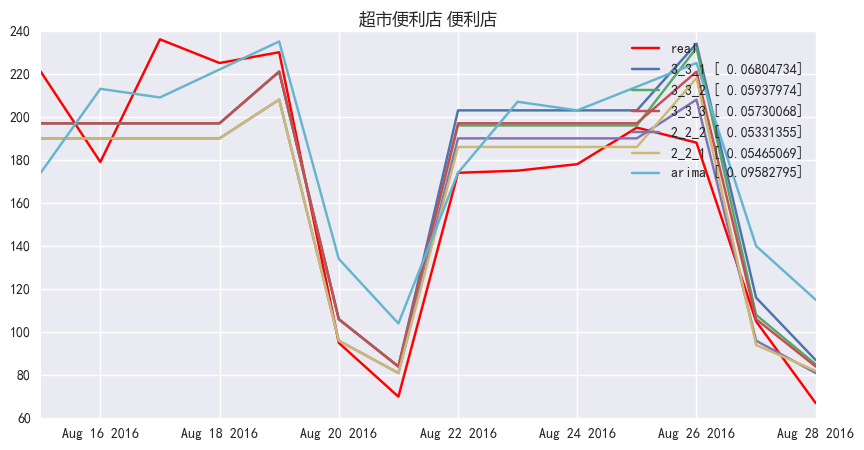

In [61]:
open_time = pd.to_datetime('2016-8-15')
end_time = pd.to_datetime('2016-8-28')
shop_id = 23
plotShopPayCounts(shop_id, [open_time, end_time], 
                  [datetime.timedelta(hours=0), datetime.timedelta(hours=23)], predict_dfs, mean_evaluation_dfs, names)

In [37]:
#3_3_1 \ 3_3_2 \ 2_2_2 \ 2_2_1 \ 3_3_3 \ arima

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [57]:
combine_df = pd.DataFrame()
for i in range(len(names)):
    combine_df[names[i]] = mean_evaluation_dfs[i]['evaluation']

In [58]:
min_index_df = combine_df.idxmin(1)

In [60]:
min_index_df

id
1       arima
2       3_3_3
3       arima
4       3_3_1
5       3_3_1
6       3_3_1
7       3_3_3
8       3_3_2
9       arima
10      arima
11      3_3_1
12      3_3_3
13      3_3_1
14      3_3_1
15      3_3_1
16      arima
17      3_3_3
18      arima
19      2_2_2
20      3_3_1
21      arima
22      3_3_2
23      2_2_2
24      2_2_2
25      3_3_3
26      arima
27      arima
28      2_2_2
29      3_3_3
30      3_3_2
        ...  
1971    3_3_1
1972    2_2_2
1973    3_3_1
1974    3_3_1
1975    2_2_1
1976    2_2_2
1977    3_3_1
1978    3_3_1
1979    arima
1980    3_3_2
1981    3_3_1
1982    3_3_3
1983    arima
1984    3_3_1
1985    3_3_3
1986    3_3_3
1987    3_3_1
1988    3_3_2
1989    2_2_2
1990    2_2_1
1991    3_3_2
1992    3_3_2
1993    arima
1994    3_3_1
1995    3_3_1
1996    arima
1997    3_3_3
1998    3_3_1
1999    3_3_2
2000    arima
dtype: object

In [72]:
diff_df = diff.to_frame()

In [76]:
diff_df[diff_df['evaluation'] > 0.01].sort_values('evaluation')

,evaluation
id,
1763,0.010038
1359,0.010065
456,0.010069
218,0.010130
1614,0.010182
902,0.010193
104,0.010193
1318,0.010199
1320,0.010261
